# Predicting the functional status of public water pumps in Tanzania
This competition is hosted by [drivendata.org](https://www.drivendata.org/competitions/7/pump-it-up-data-mining-the-water-table/), an organization who works on projects at the intersection of data science and social impact, in areas like international development, health, education, research and conservation, and public services.  
It is based on data from the Tanzanian Ministry of Water; its goal is to predict the status of public water pumps: *functional*, *needs repair*, or *working*.  

The training dataset contains the target label and 40 explanatory variables for 59,400 different pumps:  
* amount_tsh - Total static head (amount water available to waterpoint)
* date_recorded - The date the row was entered
* funder - Who funded the well
* gps_height - Altitude of the well
* installer - Organization that installed the well
* longitude - GPS coordinate
* latitude - GPS coordinate
* wpt_name - Name of the waterpoint if there is one
* num_private -
* basin - Geographic water basin
* subvillage - Geographic location
* region - Geographic location
* region_code - Geographic location (coded)
* district_code - Geographic location (coded)
* lga - Geographic location
* ward - Geographic location
* population - Population around the well
* public_meeting - True/False
* recorded_by - Group entering this row of data
* scheme_management - Who operates the waterpoint
* scheme_name - Who operates the waterpoint
* permit - If the waterpoint is permitted
* construction_year - Year the waterpoint was constructed
* extraction_type - The kind of extraction the waterpoint uses
* extraction_type_group - The kind of extraction the waterpoint uses
* extraction_type_class - The kind of extraction the waterpoint uses
* management - How the waterpoint is managed
* management_group - How the waterpoint is managed
* payment - What the water costs
* payment_type - What the water costs
* water_quality - The quality of the water
* quality_group - The quality of the water
* quantity - The quantity of water
* quantity_group - The quantity of water
* source - The source of the water
* source_type - The source of the water
* source_class - The source of the water
* waterpoint_type - The kind of waterpoint
* waterpoint_type_group - The kind of waterpoint

This notebook achieved an **accuracy of 0.7882**, getting rank 1718 out of 7999 (**top 21%**) 

**NOTE:** this is still work in progress so parts of the notebook needs better presentation/explanation**, this will come in a later phase  

In [1]:
from datetime import datetime

import numpy as np
import pandas as pd

# visualisation
import matplotlib.pyplot as plt
#set figure size
plt.rcParams['figure.figsize'] = 15, 4
import seaborn as sns
sns.set_style('whitegrid')   

# to build specific estimators
from sklearn.base import BaseEstimator, TransformerMixin
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.pipeline import Pipeline, FeatureUnion 
from sklearn.impute import SimpleImputer, MissingIndicator

from sklearn.model_selection import train_test_split #, GridSearchCV

from sklearn.neighbors import KNeighborsClassifier
from sklearn.tree import DecisionTreeClassifier 

# to display all columns of dataframe 
pd.set_option('display.max_columns', 50)

# to print all outputs in a cell instead of just the last one 
from IPython.core.interactiveshell import InteractiveShell  
InteractiveShell.ast_node_interactivity = 'all'  # 'last_expr' to revert to default behaviour 

In [2]:
# read data files
train_predictors = pd.read_csv('./input/training_X.csv')
train_target = pd.read_csv('./input/training_y.csv')
# create dataset with both label and independent variables
train_set = pd.concat([train_target[['status_group']], train_predictors], axis=1, sort=False)

# EDA
59400 observations x  40 features

In [3]:
print('Dimensions of training set = {:d} observations x  {:d} features'.format(train_predictors.shape[0], train_predictors.shape[1]))
train_set.sample(3)

Dimensions of training set = 59400 observations x  40 features


,status_group,id,amount_tsh,date_recorded,funder,gps_height,installer,longitude,latitude,wpt_name,num_private,basin,subvillage,region,region_code,district_code,lga,ward,population,public_meeting,recorded_by,scheme_management,scheme_name,permit,construction_year,extraction_type,extraction_type_group,extraction_type_class,management,management_group,payment,payment_type,water_quality,quality_group,quantity,quantity_group,source,source_type,source_class,waterpoint_type,waterpoint_type_group
40090,functional needs repair,49400,0.0,2012-10-13,Rural Water Supply And Sanita,0,DWE,31.850469,-3.289127,Miembeni,0,Lake Tanganyika,Kakoyoyo,Shinyanga,17,5,Bukombe,Ushirombo,0,True,GeoData Consultants Ltd,WUG,NaN,True,0,nira/tanira,nira/tanira,handpump,wug,user-group,unknown,unknown,soft,good,enough,enough,shallow well,shallow well,groundwater,hand pump,hand pump
9893,non functional,62569,0.0,2011-03-14,Tardo,1773,Tardo,38.285855,-4.636165,Kwa Mzee Manase,15,Pangani,Maringo,Tanga,4,1,Lushoto,Malindi,1,True,GeoData Consultants Ltd,VWC,Kiboelo forest,True,1985,gravity,gravity,gravity,vwc,user-group,never pay,never pay,soft,good,enough,enough,spring,spring,groundwater,communal standpipe,communal standpipe
33286,functional,62924,0.0,2013-02-24,District Council,1382,District Council,37.669260,-3.702595,Kwa Idd Ismail,0,Pangani,Mwerera,Kilimanjaro,3,2,Mwanga,Kirongwe,140,True,GeoData Consultants Ltd,WUA,Kindoroko water supply,False,2012,gravity,gravity,gravity,wua,user-group,never pay,never pay,unknown,unknown,insufficient,insufficient,spring,spring,groundwater,communal standpipe,communal standpipe


## Target

In [4]:
train_set['status_group'].value_counts(normalize=True)

functional                 0.543081
non functional             0.384242
functional needs repair    0.072677
Name: status_group, dtype: float64

## Features

Several features have missing values: funder, installer, subvillage, public meeting, scheme_management and scheme_name, permit.  
There is apparently no missing values for numerical variables.  
The variables *id* (id of each pump) and *recorded_by* (only one distinct value) have no explicative value and can ignored.  

In [5]:
summary = pd.DataFrame(np.array([train_predictors.dtypes, 
                                 train_predictors.isnull().sum(), 
                                 train_predictors.nunique()]),
                       index=['Dtype', 'NbrNullValues', 'NbrDistinctVal'],                                 
                       columns=np.array(list(train_predictors)))
display(summary)

col_to_drop = ['id', 'recorded_by', 'wpt_name', 'subvillage']

,id,amount_tsh,date_recorded,funder,gps_height,installer,longitude,latitude,wpt_name,num_private,basin,subvillage,region,region_code,district_code,lga,ward,population,public_meeting,recorded_by,scheme_management,scheme_name,permit,construction_year,extraction_type,extraction_type_group,extraction_type_class,management,management_group,payment,payment_type,water_quality,quality_group,quantity,quantity_group,source,source_type,source_class,waterpoint_type,waterpoint_type_group
Dtype,int64,float64,object,object,int64,object,float64,float64,object,int64,object,object,object,int64,int64,object,object,int64,object,object,object,object,object,int64,object,object,object,object,object,object,object,object,object,object,object,object,object,object,object,object
NbrNullValues,0,0,0,3635,0,3655,0,0,0,0,0,371,0,0,0,0,0,0,3334,0,3877,28166,3056,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
NbrDistinctVal,59400,98,356,1897,2428,2145,57516,57517,37400,65,9,19287,21,27,20,125,2092,1049,2,1,12,2696,2,55,18,13,7,12,5,7,7,8,6,5,5,10,7,3,7,6


## Numerical features

Several numerical variables preset a high number of 0 values, which probably corresponds to missing value.  
*region_code* and *district_code* are ordinal categorical features. We will process them with the other categorical variables.

In [6]:
# extract all numerical variables plus target
train_num = train_predictors.select_dtypes(include=np.number)
train_num = pd.concat([train_num, train_target], axis=1)
train_num = train_num.drop(labels='id', axis=1)

train_num.describe()

,amount_tsh,gps_height,longitude,latitude,num_private,region_code,district_code,population,construction_year
count,59400.000000,59400.000000,59400.000000,5.940000e+04,59400.000000,59400.000000,59400.000000,59400.000000,59400.000000
mean,317.650385,668.297239,34.077427,-5.706033e+00,0.474141,15.297003,5.629747,179.909983,1300.652475
std,2997.574558,693.116350,6.567432,2.946019e+00,12.236230,17.587406,9.633649,471.482176,951.620547
min,0.000000,-90.000000,0.000000,-1.164944e+01,0.000000,1.000000,0.000000,0.000000,0.000000
25%,0.000000,0.000000,33.090347,-8.540621e+00,0.000000,5.000000,2.000000,0.000000,0.000000
50%,0.000000,369.000000,34.908743,-5.021597e+00,0.000000,12.000000,3.000000,25.000000,1986.000000
75%,20.000000,1319.250000,37.178387,-3.326156e+00,0.000000,17.000000,5.000000,215.000000,2004.000000
max,350000.000000,2770.000000,40.345193,-2.000000e-08,1776.000000,99.000000,80.000000,30500.000000,2013.000000


In [7]:
# define function to perform eda on numerical variables
def eda_numerical_variable(col, transform='none'):
    # create df and add column coding for 0 value
    df = train_num[['status_group',col]].copy()
    df['is_zero'] = (train_num[col] == 0)

    # frequency of 0 value
    print('NUMERICAL VARIABLE: ' + col)
    print('percentage of 0 value = {:.2f}%'.format(df[df.is_zero == True].shape[0]/train_num.shape[0]*100))
   
    if transform == 'log':
        df[col] = df[col].apply(lambda x: np.log(x))

    sns.catplot(x='status_group', y=col, data=df[df.is_zero == False], kind='box');

NUMERICAL VARIABLE: amount_tsh
percentage of 0 value = 70.10%


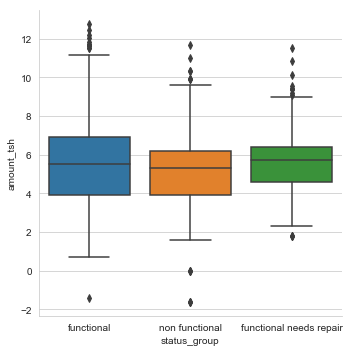

In [8]:
# amount_tsh - Total static head (amount water available to waterpoint)
eda_numerical_variable('amount_tsh', 'log')

NUMERICAL VARIABLE: gps_height
percentage of 0 value = 34.41%


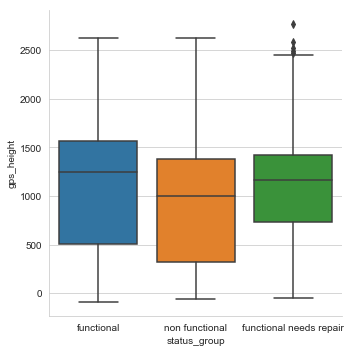

In [9]:
# gps_height - Altitude of the well
eda_numerical_variable('gps_height')

NUMERICAL VARIABLE: longitude
percentage of 0 value = 3.05%


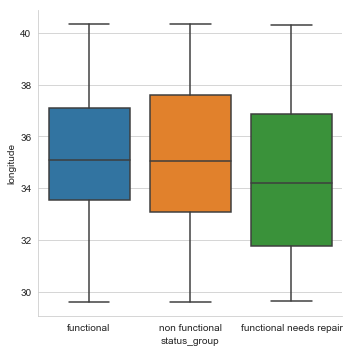

In [10]:
# longitude - GPS coordinate
eda_numerical_variable('longitude')
col_to_drop.append('longitude')

NUMERICAL VARIABLE: latitude
percentage of 0 value = 0.00%


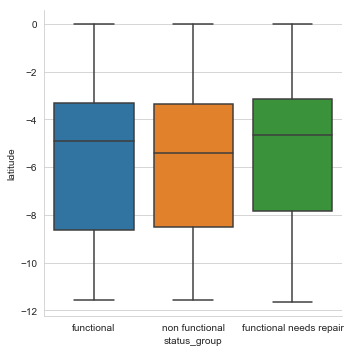

In [11]:
# latitude - GPS coordinate
eda_numerical_variable('latitude')
col_to_drop.append('latitude')

NUMERICAL VARIABLE: num_private
percentage of 0 value = 98.73%


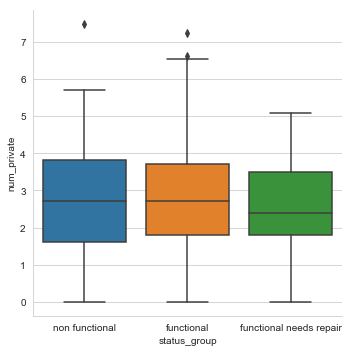

In [12]:
# num_private -
eda_numerical_variable('num_private', 'log')
col_to_drop.append('num_private')

NUMERICAL VARIABLE: population
percentage of 0 value = 35.99%


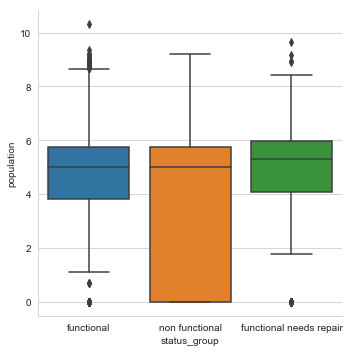

In [13]:
# population - Population around the well
eda_numerical_variable('population', 'log')

NUMERICAL VARIABLE: construction_year
percentage of 0 value = 34.86%


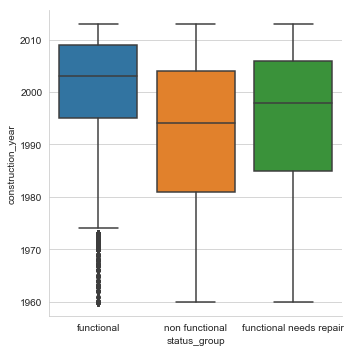

In [14]:
# construction_year - Year the waterpoint was constructed
eda_numerical_variable('construction_year')

#### Plan for Feature Engineering of numerical features
Based on the above results, we plan Feature Engineering of numerical variables as follows:
* drop variable 'num_private'
* for the other features 'amount_tsh', 'gps_height', 'longitude', 'latitude', 'population', 'construction_year': 
    - replace 0 with NaN
    - create a new feature coding for missing value     
    - map NaN to median

In [15]:
col_to_drop = ['num_private']
col_numerical_fe1 = ['amount_tsh', 'gps_height', 'longitude', 'latitude', 'population', 'construction_year']

## Categorical features

In [16]:
train_cat = train_predictors.copy()
train_cat = pd.concat([train_cat, train_target], axis=1)
train_cat.drop(labels=['longitude', 'latitude', 'num_private',
                       'amount_tsh', 'gps_height', 'population', 'construction_year',
                       'id', 'recorded_by', 'wpt_name', 'subvillage'], axis=1, inplace=True)

train_cat.sample(5)

,date_recorded,funder,installer,basin,region,region_code,district_code,lga,ward,public_meeting,scheme_management,scheme_name,permit,extraction_type,extraction_type_group,extraction_type_class,management,management_group,payment,payment_type,water_quality,quality_group,quantity,quantity_group,source,source_type,source_class,waterpoint_type,waterpoint_type_group,status_group
56493,2013-04-04,Government Of Tanzania,Government,Pangani,Kilimanjaro,3,4,Moshi Rural,Mabogini,True,Water authority,Coffee curing-Kahe pipeline,True,gravity,gravity,gravity,water authority,commercial,pay monthly,monthly,soft,good,insufficient,insufficient,spring,spring,groundwater,communal standpipe,communal standpipe,functional
27969,2011-04-03,Government Of Tanzania,Central Government,Rufiji,Mbeya,12,2,Mbeya Rural,Inyala,True,VWC,NaN,True,gravity,gravity,gravity,wug,user-group,pay annually,annually,soft,good,insufficient,insufficient,river,river/lake,surface,communal standpipe,communal standpipe,functional
23130,2011-02-26,Dhv,DWE,Wami / Ruvu,Morogoro,5,6,Mvomero,Mvomero,True,VWC,NaN,True,swn 80,swn 80,handpump,vwc,user-group,pay annually,annually,soft,good,insufficient,insufficient,shallow well,shallow well,groundwater,hand pump,hand pump,functional
1938,2011-04-02,NaN,NaN,Rufiji,Mbeya,12,7,Mbarali,Mawindi,True,WUA,NaN,True,gravity,gravity,gravity,wua,user-group,never pay,never pay,soft,good,seasonal,seasonal,river,river/lake,surface,communal standpipe,communal standpipe,functional
38388,2011-07-24,Concern,TWESA,Lake Victoria,Kagera,18,30,Ngara,Kabanga,True,VWC,NaN,False,nira/tanira,nira/tanira,handpump,vwc,user-group,never pay,never pay,soft,good,enough,enough,shallow well,shallow well,groundwater,hand pump,hand pump,non functional


In [17]:
summary = pd.DataFrame(np.array([train_cat.dtypes, 
                                 train_cat.isnull().sum(), 
                                 train_cat.nunique()]),
                       index=['Dtype', 'NbrNullValues', 'NbrDistinctVal'],                                 
                       columns=np.array(list(train_cat)))
display(summary)

# code NaN value as 'missing' 
train_cat.fillna(value='missing_value', inplace=True)

,date_recorded,funder,installer,basin,region,region_code,district_code,lga,ward,public_meeting,scheme_management,scheme_name,permit,extraction_type,extraction_type_group,extraction_type_class,management,management_group,payment,payment_type,water_quality,quality_group,quantity,quantity_group,source,source_type,source_class,waterpoint_type,waterpoint_type_group,status_group
Dtype,object,object,object,object,object,int64,int64,object,object,object,object,object,object,object,object,object,object,object,object,object,object,object,object,object,object,object,object,object,object,object
NbrNullValues,0,3635,3655,0,0,0,0,0,0,3334,3877,28166,3056,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
NbrDistinctVal,356,1897,2145,9,21,27,20,125,2092,2,12,2696,2,18,13,7,12,5,7,7,8,6,5,5,10,7,3,7,6,3


### Categorical features to transform to dummy variables
Feature **basin** seems to have high explanatory power (see for example *Ruvuma* and *Lake Rukwa* values with higher proportion of *non functional* than *functional* status). We keep it and we will map it to dummy variables.

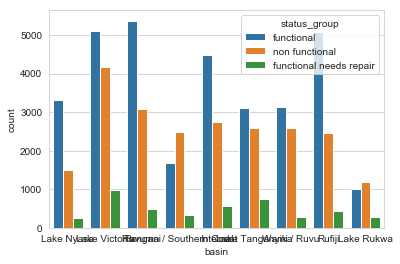

In [18]:
sns.countplot(x='basin', hue='status_group', data=train_cat);
col_categorical_onehot = ['basin']

Feature **public_meeting** is a boolean feature. It will be transformed to dummy variables after mapping NAN to *missing_value*

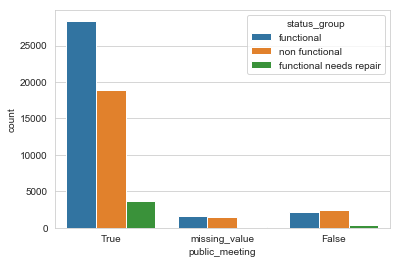

In [19]:
sns.countplot(x='public_meeting', hue='status_group', data=train_cat);
col_categorical_onehot.append('public_meeting')

Feature **scheme_management** will be mapped as dummy variables.  

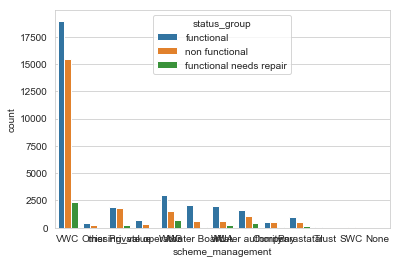

In [20]:
sns.countplot(x='scheme_management', hue='status_group', data=train_cat);
col_categorical_onehot.append('scheme_management')

Feature **permit** will be transformed to dummy variables after mapping NAN to *missing_value*

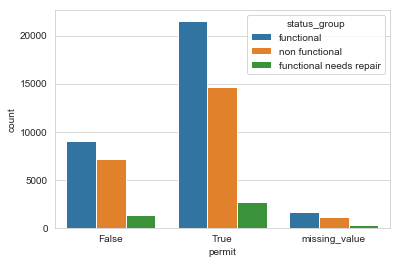

In [21]:
sns.countplot(x='permit', hue='status_group', data=train_cat);
col_categorical_onehot.append('permit')

All 3 features **extraction_type**, **extraction_type_group** and **extraction_type_class** code for similar information. The first two features contain more values but only with very low frequencies. For now, we will keep only *extraction_type_class' and map it later to dummies.  

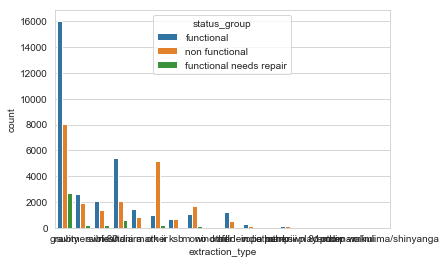

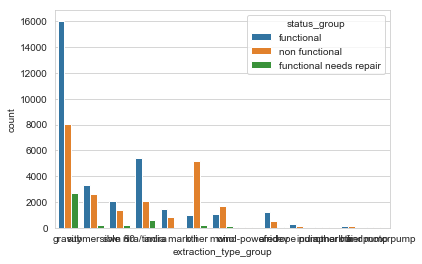

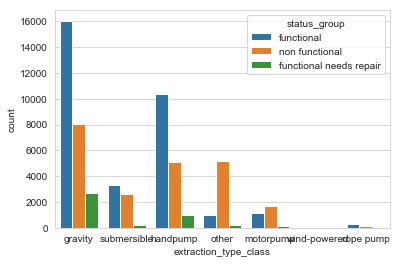

In [22]:
sns.countplot(x='extraction_type', hue='status_group', data=train_cat);
plt.show()
sns.countplot(x='extraction_type_group', hue='status_group', data=train_cat);
plt.show()
sns.countplot(x='extraction_type_class', hue='status_group', data=train_cat);
col_categorical_onehot.append('extraction_type_class')

The 2 features **management** and **management_group** do not look very informative. We drop them at least for now.  

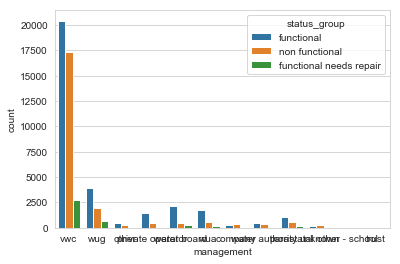

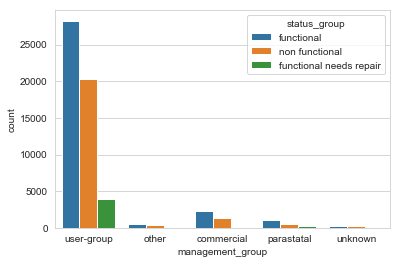

In [23]:
sns.countplot(x='management', hue='status_group', data=train_cat);
plt.show()
sns.countplot(x='management_group', hue='status_group', data=train_cat);

The 2 features **payment** and **payment_type** are identical. They definitively exhibit predictive power (see value *dry* for example ). We keep only *payment_type* and will map it to dummy variables.

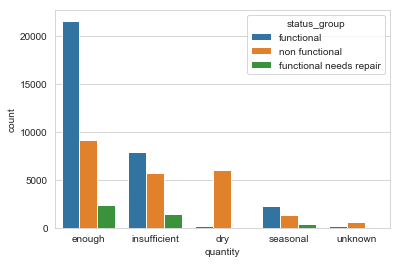

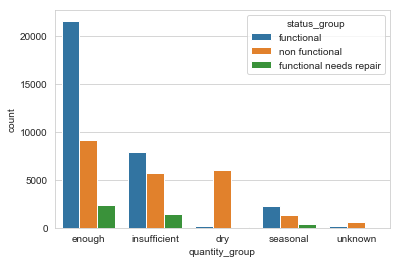

In [24]:
sns.countplot(x='quantity', hue='status_group', data=train_cat)
plt.show()
sns.countplot(x='quantity_group', hue='status_group', data=train_cat);
col_categorical_onehot.append('quantity_group')

The features **water_quality** and **quality_group** contain for similar information. Feature *water_quality* may be slightly more informative as it contains 2 additional values (*salty abandoned* and *fluoride abandoned*), but they have very low frequency. Since the addition informative power lokks negligeable, we keep only *quality_group* to reduce the number of dummy variables during FE.

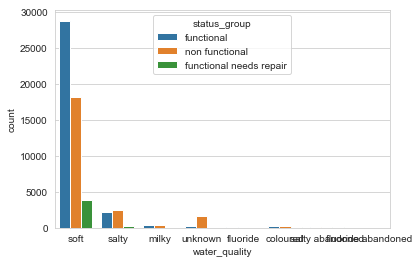

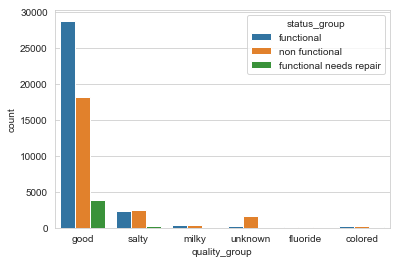

In [25]:
sns.countplot(x='water_quality', hue='status_group', data=train_cat);
plt.show()
sns.countplot(x='quality_group', hue='status_group', data=train_cat);
col_categorical_onehot.append('quality_group')

The 2 features **quantity** and **quantity_group** are identical, we keep only *quantity_group* and will transform it to dummy variables.

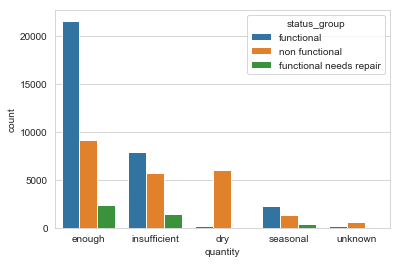

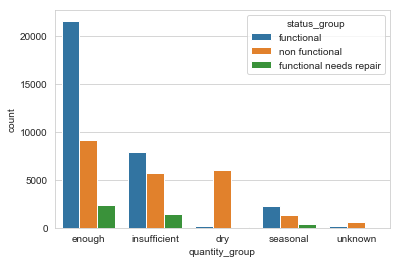

In [26]:
sns.countplot(x='quantity', hue='status_group', data=train_cat)
plt.show()
sns.countplot(x='quantity_group', hue='status_group', data=train_cat);
col_categorical_onehot.append('quantity_group')

The features **source**, **source_type**, **source_class** code for related information. Feature *source* contains slightly more information than *source_type*, so we will keep it and drop *source_type*. We will also drop *source_class* since it does not look very informative.

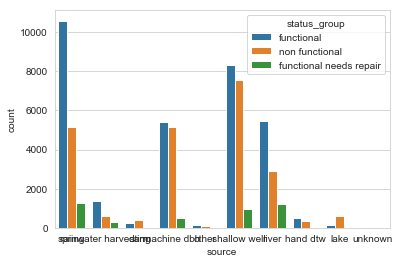

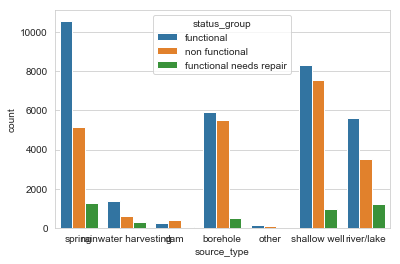

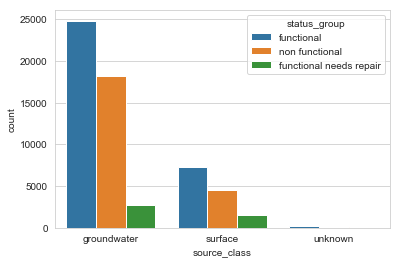

In [27]:
sns.countplot(x='source', hue='status_group', data=train_cat);
plt.show()
sns.countplot(x='source_type', hue='status_group', data=train_cat);
plt.show()
sns.countplot(x='source_class', hue='status_group', data=train_cat);
col_categorical_onehot.append('source')

The features **waterpoint_type** and **waterpoint_type_group** code for similar information, but *waterpoint_type* has one categorie more (*communal standpipe multiple*) and is more informative. We keep only feature *waterpoint_type* and will map it to dummy variables.

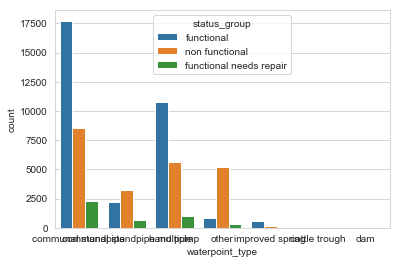

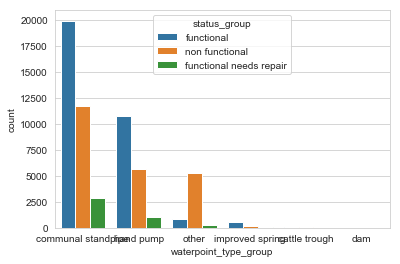

In [28]:
sns.countplot(x='waterpoint_type', hue='status_group', data=train_cat);
plt.show()
sns.countplot(x='waterpoint_type_group', hue='status_group', data=train_cat);
col_categorical_onehot.append('waterpoint_type')

### High cardinality variables
5 variables with high cardinality: 'funder', 'installer', 'lga', 'ward', 'scheme_name' (ignore this one)
will be process during FE by mapping them to a numeric function. Ignore them during EDA

In [29]:
# TODO check if we include wpt_name and  subvillage 
col_high_cardinality = ['funder', 'installer', 'lga', 'ward']

#### region and region_code
keep one of them, treat as high cardinality

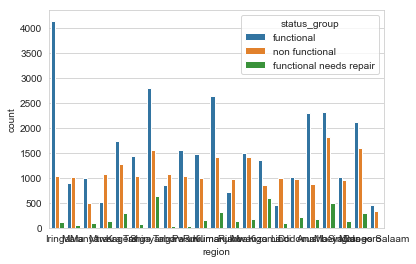

In [30]:
sns.countplot(x='region', hue='status_group', data=train_cat);
col_to_drop.append('region')
col_high_cardinality.append('region_code')

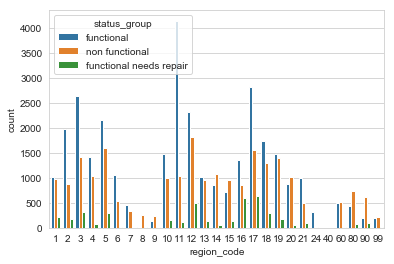

In [31]:
sns.countplot(x='region_code', hue='status_group', data=train_cat);

#### district_code
probably not very informative but process it as high cardinality

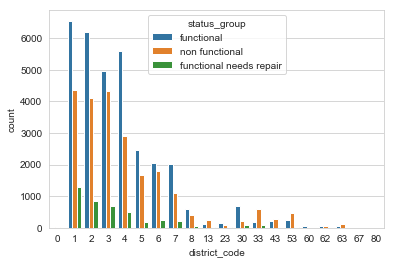

In [32]:
sns.countplot(x='district_code', hue='status_group', data=train_cat);
col_high_cardinality.append('district_code')

#### TODO EDA and FE for date_recorded

#### Summary
Plan for Feature Engineering of categorical variables:
* drop 'region', 'scheme_management', 'scheme_name', 'extraction_type', 'extraction_type_class', 'payment', 'water_quality', 'quantity', 'source_type', 'source_class', 'waterpoint_type_group'
* drop for now 'management', 'management_group'
* process as high cardinality 'funder', 'installer', 'lga', 'ward' and 'region_code', 'district_code', 'extraction_type_group'
* transform to dummy variables 'basin', 'payment_type', 'quality_group', 'quantity_group', 'source', 'waterpoint_type'
* transform to dummy variables 'public_meeting', 'permit'

## Feature Engineering

In [33]:
# handle the target with mapping
train_target['status_group'] = train_target['status_group'].map({'functional': 0, 
                                                                 'functional needs repair': 1, 
                                                                 'non functional': 2})

This dataset contains several categorical variables with very high cardinality, like for example *funder* with 1897 unique values. There are 3 approaches possible to handle this type of features:
* group together values that have close meaning (this is however not possible for variables like *funder* for which there is no clear proximity measure between different values)
* discard values with low frequencies (possible, but this would probably be unsufficient to reduce enough the number of unique values)
* **transform the initial feature into a continuous numerical feature**  

We will use option 3, and we define 3 functions $f_F$, $f_R$ and $f_N$:
$$f_F(x) = \frac{N_F(x) + p_F}{N(x) + 1}$$  
$$f_R(x) = \frac{N_R(x) + p_R}{N(x) + 1}$$  
$$f_N(x) = \frac{N_N(x) + p_N}{N(x) + 1}$$ 
where:
* $x$ is a given value of the high cardinality variable V, 
* $N_F(x)$, $N_R(x)$ and $f_N(x)$ are the number of observations with V=x and respectively equal to Functional, Repair, and Non Functional 
* $N(x)$ is the total number of observations with V=X, with $N(x) = N_F(x) + N_R(x) + f_N(x)$
* $p_F$, $p_R$ and $p_N$ are the frequencies over the full set of status Functional, Repair, and Non Functional  
  
Now, it is easy to see that the sum of $f_F$, $f_R$ and $f_N$ is equal to 1 and that these 3 functions can be considered as probabilities of each status: 
$$f_F(x) + f_R(x) + f_N(x) = \frac{N_F(x) + p_F + N_R(x) + p_R + N_N(x) + p_N}{N(x) + 1}
= \frac{N_F(x) + N_R(x) + N_N(x) + p_F + p_R + p_N}{N(x) + 1} = \frac{N(x) + 1}{N(x) + 1}$$  

The rationale for these functions is:
* their value gets closer to the observed frequencies $\frac{N_F(x)}{N(x)}$ as the number of observations $N(x)$ increases. Thus they are putting more weight on frequent values 
* they have an intuitive meaning as estimation of probabilities
* they are defined even if the value x is not included in the training set  

In [34]:
# define transformer to transform high cardinality variables to numerical functions

#### TODO remove hardcoded labels

class HighCardinalityTransformer(BaseEstimator, TransformerMixin):
    def __init__(self, alpha=3):
        self._frequencies = {}
        self._label_values = []
        self._mapper = {}
        self._alpha = alpha
        pass
    
    def fit(self, X, y):
        # both X and y must be DF
        # convert y to string to have a fixed and known type  
        y_str = y.astype(str)
        
        # self._label_values = ['functional', 'functional needs repair', 'non functional']
        self._label_values = ['0', '1', '2']        
        
        # compute frequencies over full data
        self._default_frequencies = {}
        for status in self._label_values: 
            self._frequencies[status] = np.count_nonzero(y_str == status) / y_str.shape[0]  
        
        # get list of all columns in X 
        columns_to_map = list(X)
        
        self._mapper = {}
        for col in columns_to_map:
            # create df with the variable to map and the label
            df = pd.concat([X[col],y], axis=1)
            df.rename(columns={y.columns.values[0]: 'y'}, inplace=True)
            
            # replace y with 3 columns 'y_functional', 'y_functional needs repair', 'y_non functional' with counts 
            df = pd.get_dummies(data=df, columns=['y'])
            df = df.groupby(col).sum()
            
#            df['count'] = df['y_functional'] +  df['y_functional needs repair'] + df['y_non functional']
            df['count'] = df['y_0'] +  df['y_1'] + df['y_2']            
            # calculate the 3 probability estimates
#            df['functional'] = (df['y_functional'] + self._frequencies['functional']) / (df['count'] + 1)
#            df['functional needs repair'] = (df['y_functional needs repair'] + self._frequencies['functional needs repair']) / (df['count'] + 1)
#            df['non functional'] = (df['y_non functional'] + self._frequencies['non functional']) / (df['count'] + 1) 
            df['0'] = (df['y_0'] + self._alpha *self._frequencies['0']) / (df['count'] + self._alpha)
            df['1'] = (df['y_1'] + self._alpha * self._frequencies['1']) / (df['count'] + self._alpha)
            df['2'] = (df['y_2'] + self._alpha * self._frequencies['2']) / (df['count'] + self._alpha) 
            
            # create mapper with format:
            #     {'col1': {'functional': {val1: f1, val2: f2, ...},
            #               'functional needs repair': {val1: f1, val2: f2, ...},
            #               'non functional': {val1: f1, val2: f2, ...}}, 
            #      'col2': ...}
            self._mapper[col] = df[['0', '1', '2']].to_dict()
            
        return self
    
    def transform(self, X, y=None):
        res = X.copy()
        
        for col_name in list(X):
            for y_name in self._label_values:
                mapper = self._mapper[col_name][y_name]
                new_col = col_name + '_f_' + y_name
                res[new_col] = X[col_name].map(mapper)
                
                # fill NA value with frequency of corresponding status - TODO not tested 
                res[new_col] = res[new_col].fillna(value=self._frequencies[y_name])
             
        #drop initial columns
        res.drop(list(X), axis=1, inplace=True)
        return res
    
    def get_frequencies(self):        
        return self._frequencies
    
    def get_mapper(self):
        return self._mapper   
    
# example: transform 2 categorical values to numeric functions    
hct = HighCardinalityTransformer()
hct.fit(train_predictors[['region','lga']], train_target[['status_group']])
res = hct.transform(train_predictors[['region','lga']])
res.head(3)

HighCardinalityTransformer(alpha=None)

,region_f_0,region_f_1,region_f_2,lga_f_0,lga_f_1,lga_f_2
0,0.782071,0.023262,0.194667,0.773597,0.019785,0.206619
1,0.450116,0.030537,0.519347,0.591974,0.037855,0.370171
2,0.623348,0.060667,0.315985,0.580801,0.016778,0.402420


#### prepare data


In [35]:
# implement pipeline

class DataFrameSelector(BaseEstimator, TransformerMixin):
    '''returns a NumPy array corresponding to the attributes in the list given as argument for the constructor'''
    def __init__(self, attribute_names):
        self._attribute_names = attribute_names
    
    def fit(self, X, y=None):
        return self
    
    def transform(self, X):
        return X[self._attribute_names] #.values
    
num_pipeline = Pipeline([
    ('selector', DataFrameSelector(col_numerical_fe1)),
    ('imputer1', SimpleImputer(missing_values=0, fill_value=np.nan)),
#    ('indicator', MissingIndicator()),  # TODO doesnot work - add_indicator not available before 0.21.3
    ('imputer2', SimpleImputer(strategy='median')), #, add_indicator=True)),
    ('scaler', StandardScaler()),
    ])    

# pipeline for boolean/categorical features encoded with OneHot
cat_pipeline_1 = Pipeline([
    ('selector', DataFrameSelector(col_categorical_onehot)),
    ('imputer1', SimpleImputer(strategy='constant', fill_value='missing_values')),    
    ('encoder', OneHotEncoder(sparse=False, handle_unknown='error')),  # upgrade version for drop drop 
#    ('indicator', MissingIndicator()),  # TODO doesnot work - add_indicator not available before 0.21.3  
    ('imputer2', SimpleImputer(strategy='median')), #, add_indicator=True)),
    ('scaler', StandardScaler()),
    ]) 

# pipeline for high cardinality categorical features
cat_hc_pipeline = Pipeline([
    ('selector', DataFrameSelector(col_high_cardinality)),
    ('high_cardinality', HighCardinalityTransformer()),
#    ('indicator', MissingIndicator()),  # TODO doesnot work - add_indicator not available before 0.21.3
    ('imputer2', SimpleImputer(strategy='median')), #, add_indicator=True)),
    ('scaler', StandardScaler()),
    ]) 

full_pipeline = FeatureUnion([
    ('num1', num_pipeline),
    ('cat1', cat_pipeline_1),  
    ('hc', cat_hc_pipeline)
    ])

In [36]:
def prepare_X(X):
    df = X.copy()
    
    # group similar values
    df.loc[:,'scheme_management'] = df['scheme_management'].replace(to_replace='None', value='Other')
    df.loc[:,'scheme_management'] = df['scheme_management'].replace(to_replace='missing', value='Other')
    
    # TODO - REMOVE ONCE DONE 
    df.drop(labels='date_recorded', axis=1, inplace=True)
    
    # transform boolean features to string
    for col in ['public_meeting', 'permit']:
        df.loc[:,col] = df[col].map({True: 'true', False: 'false'}, na_action='ignore')
    
    return df    
   
X_prep = prepare_X(train_predictors)  
X_prep.head(3)

,id,amount_tsh,funder,gps_height,installer,longitude,latitude,wpt_name,num_private,basin,subvillage,region,region_code,district_code,lga,ward,population,public_meeting,recorded_by,scheme_management,scheme_name,permit,construction_year,extraction_type,extraction_type_group,extraction_type_class,management,management_group,payment,payment_type,water_quality,quality_group,quantity,quantity_group,source,source_type,source_class,waterpoint_type,waterpoint_type_group
0,69572,6000.0,Roman,1390,Roman,34.938093,-9.856322,none,0,Lake Nyasa,Mnyusi B,Iringa,11,5,Ludewa,Mundindi,109,true,GeoData Consultants Ltd,VWC,Roman,false,1999,gravity,gravity,gravity,vwc,user-group,pay annually,annually,soft,good,enough,enough,spring,spring,groundwater,communal standpipe,communal standpipe
1,8776,0.0,Grumeti,1399,GRUMETI,34.698766,-2.147466,Zahanati,0,Lake Victoria,Nyamara,Mara,20,2,Serengeti,Natta,280,NaN,GeoData Consultants Ltd,Other,NaN,true,2010,gravity,gravity,gravity,wug,user-group,never pay,never pay,soft,good,insufficient,insufficient,rainwater harvesting,rainwater harvesting,surface,communal standpipe,communal standpipe
2,34310,25.0,Lottery Club,686,World vision,37.460664,-3.821329,Kwa Mahundi,0,Pangani,Majengo,Manyara,21,4,Simanjiro,Ngorika,250,true,GeoData Consultants Ltd,VWC,Nyumba ya mungu pipe scheme,true,2009,gravity,gravity,gravity,vwc,user-group,pay per bucket,per bucket,soft,good,enough,enough,dam,dam,surface,communal standpipe multiple,communal standpipe


In [37]:
X_prep = full_pipeline.fit_transform(X_prep, train_target[['status_group']])
print(X_prep.shape)

# get train and test set 
X_train, X_test, y_train, y_test = train_test_split(X_prep, train_target[['status_group']], test_size=0.20, random_state=42)

(59400, 91)


## Shortlist candidate models

In [38]:
knn = KNeighborsClassifier(n_neighbors=3, p=1)
knn.fit(X_train, y_train) 

y_pred = knn.predict(X_test)

from sklearn.metrics import accuracy_score
accuracy = accuracy_score(y_test, y_pred)
print('accuracy = {:.4f}'.format(accuracy))

C:\Users\CEDRIC\Anaconda3\envs\datascience\lib\site-packages\ipykernel_launcher.py:2: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  


KNeighborsClassifier(algorithm='auto', leaf_size=30, metric='minkowski',
           metric_params=None, n_jobs=None, n_neighbors=3, p=1,
           weights='uniform')

accuracy = 0.7860


In [39]:
# TODO - to implement later
#dtc = DecisionTreeClassifier(random_state=0)

#dtc.fit(X_train, y_train)  

#y_pred = dtc.predict(X_test)
#accuracy = accuracy_score(y_test, y_pred)
#print('accuracy = {:.4f}'.format(accuracy))

# Make submision


In [40]:
# read test data
test_predictors = pd.read_csv('./input/test_X.csv')
# do basic FE
X_test = prepare_X(test_predictors) 
X_test = full_pipeline.transform(X_test)

y_test = knn.predict(X_test)

In [41]:
submission = test_predictors[['id']].copy()
submission['status_group'] = y_test
submission['status_group'] = submission['status_group'].map({0: 'functional', 
                                                             1: 'functional needs repair', 
                                                             2: 'non functional'})

In [42]:
submission.to_csv('./output/submission.csv', 
                columns=['id', 'status_group'],
                header=True,
                index=False)